# Machine learning: k-Means Clustering

### 1. Import of the libraries



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Generation of data

We generate and visualize the random data points for clustering.

In [2]:
# Set random seed for reproducibility

np.random.seed(5)


Setting a random seed ensures we get the same random numbers each time we run the code. This is useful for:

* Reproducible results
* Debugging
* Comparisons between different algorithms

In [3]:
# Generate three different clusters of points

# Cluster 1
X1 = 2 * np.random.rand(50, 2)


# np.random.rand(50, 2) generates random numbers between 0 and 1
# Multiplying by 2 scales points to be between 0 and 2
# Shape: (50, 2) means 50 points with 2 coordinates (x, y)


# Cluster 2
X2 = 2 + 2 * np.random.rand(50, 2)

# First multiplies random numbers by 2 (scale between 0 and 2)
# Then adds 2 (shifts points right/up by 2)
# Final points are between 2 and 4 on both axes


# Cluster 3
X3 = 4 + 2 * np.random.rand(50, 2)

# Similar to X2 but shifts by 4 instead of 2
# Final points are between 4 and 6 on both axes

# Combine all three clusters into one array
X = np.concatenate((X1, X2, X3))


Finally, plot all points:

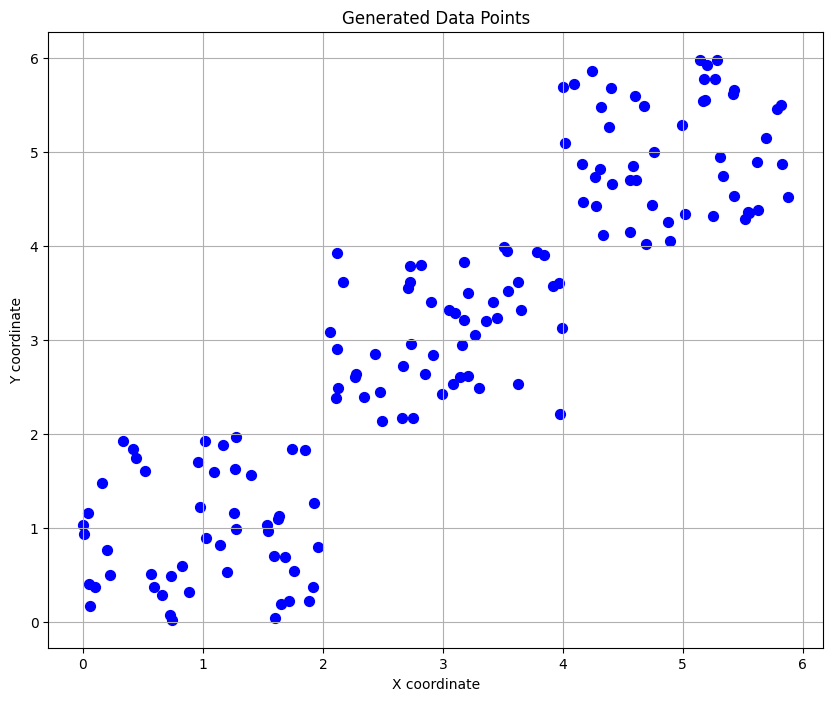

In [4]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c='b', s=50)
# X[:, 0] takes all x-coordinates
# X[:, 1] takes all y-coordinates
# c='b' sets color to blue
# s=50 sets point size to 50

plt.title('Generated Data Points')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.show()

### 3. K-Means Clustering Implementation from Scratch

The class is initialized with three main parameters:


*   ***n_clusters***: number of clusters (k)
*   ***max_iters***: maximum number of iterations for each initialization
 * Prevents infinite loops
 * Algorithm stops when either:
a) Convergence is reached (centroids stop moving);
b) max_iters is reached
*   ***n_init***: number of times to run the algorithm with different initializations
 * Number of times to run algorithm with different random starts
 * Helps avoid poor local minima


===========================================================================================================

The class has additional inner parameters:


*   ***cluster_centers_*** will store the final centroid coordinates and the shape will be (n_clusters, n_features)
*   ***labels_***   will store cluster assignments for each data point (array of integers from 0 to n_clusters-1)
*   ***inertia_*** will store the sum of squared distances to closest centroid (lower values indicate better clustering)


===========================================================================================================

Let's break down this KMeans clustering implementation in detail and go through the main components:


**Step 1: Class Initialization (*_init_*)**

**Step 2: Centroid Initialization (*init_centroids*)**

* First centroid is randomly chosen from data points
* Subsequent centroids are chosen with probability proportional to their squared distance from existing centroids
* This method helps avoid poor initializations that basic random selection might create



**Step 3: Cluster Assignment (*assign_clusters*)**

* Calculates Euclidean distance between each point and all centroids
* Assigns each point to the nearest centroid using *argmin*
* Returns an array of cluster labels for each data point


**Step 4: Centroid Update (*update_centroids*)**

* Updates centroid positions by calculating the mean of all points in each cluster
* Includes debugging print statements to show:

 * Number of points in each cluster
 * Points in each cluster
 * New centroid positions


* Returns updated centroid positions


**Step 5: Inertia Computation (*compute_inertia*)**

* Calculates the sum of squared distances between points and their assigned centroids
* This is a measure of how compact/coherent the clusters are
* Lower inertia indicates better clustering


**Step 6: Main Fitting Method (*fit*)**

The core method that:

* Runs the algorithm n_init times with different initializations
* For each initialization:

 * Initializes centroids using k-means++
 * Iteratively assigns clusters and updates centroids until convergence
 * Computes inertia


* Keeps track of the best result (lowest inertia)
* Stores the best centroids, labels, and inertia


**Step 7: Prediction Method (*predict*)**

 * Used for assigning cluster labels to new data points
 * Uses the trained model's centroids to assign clusters
 * Raises an error if the model hasn't been fitted yet


In [7]:
class KMeansClustering:
    def __init__(self, n_clusters=3, max_iters=100, n_init=10):

        """
        Initialize KMeansClustering class

        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters to form
        max_iters : int, default=100
            Maximum number of iterations for each run
        n_init : int, default=10
            Number of times algorithm will run with different initializations
        """

        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.n_init = n_init
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None


    def _euclidean_distance_2d(self, point1, point2):
        """Calculate Euclidean distance between two 2D points"""
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


    def _init_centroids(self, X):

        """Initialize centroids using k-means++ algorithm"""


        # Create empty array to store centroids
        n_samples = len(X)                                                       # n_samples: number of data points
        centroids = np.zeros((self.n_clusters, 2))

        # Randomly select one point as the first centroid
        first_centroid_idx = np.random.randint(n_samples)
        centroids[0] = X[first_centroid_idx]


        # Choose remaining centroids
        for k in range(1, self.n_clusters):
            # Calculate distances to nearest centroid for each point
            # 1. For each existing centroid:
            #    - Calculate distance from every point to this centroid
            # 2. For each point:
            #    - Take the minimum distance to any existing centroid

            min_distances = np.zeros(n_samples)
            for i in range(n_samples):
                distances = []
                for j in range(k):
                    dist = self._euclidean_distance_2d(X[i], centroids[j])
                    distances.append(dist)
                min_distances[i] = min(distances) ** 2

            # Choose next centroid with probability proportional to distance squared
            # Convert distances to probabilities
            probs = min_distances / np.sum(min_distances)
            # Calculate cumulative probabilities
            cumprobs = np.cumsum(probs)
            # Generate random number between 0 and 1
            r = np.random.rand()

            # Choose point based on where random number falls
            for j, p in enumerate(cumprobs):
                if r < p:
                    centroids[k] = X[j]
                    break

        return centroids

    def _assign_clusters(self, X, centroids):


            """
            This function: Calculates Euclidean distances between each point and all centroids
            and assigns each point to the nearest centroid using argmin

            """

            n_samples = len(X)
            labels = np.zeros(n_samples, dtype=int)

            for i in range(n_samples):
                min_dist = float('inf')
                min_cluster = 0

                for k in range(self.n_clusters):
                    dist = self._euclidean_distance_2d(X[i], centroids[k])
                    if dist < min_dist:
                        min_dist = dist
                        min_cluster = k

                labels[i] = min_cluster

            return labels


    def _update_centroids(self, X, labels):

            """Update centroids based on mean of points in each cluster"""
            # Create empty array for new centroids
            centroids = np.zeros((self.n_clusters, 2))

            # For each cluster
            for k in range(self.n_clusters):

                # Count points in current cluster
                points_in_cluster = []
                # Get points in current cluster
                for i in range(len(X)):
                  if labels[i] == k:
                      points_in_cluster.append(X[i])

                # Check if cluster is not empty
                if points_in_cluster:

                    # Calculate new centroid as mean of all points in cluster
                    x_sum = sum(point[0] for point in points_in_cluster)
                    y_sum = sum(point[1] for point in points_in_cluster)
                    n_points = len(points_in_cluster)
                    centroids[k] = [x_sum/n_points, y_sum/n_points]

            return centroids

    def _compute_inertia(self, X, labels, centroids):

            """
            Compute sum of squared distances of points to their assigned centroids.
            Inertia measures how internally coherent clusters are.
            """
            total_distance = 0
            # Calculate distances between points and their assigned centroids
            for i in range(len(X)):
              cluster = labels[i]
              dist = self._euclidean_distance_2d(X[i], centroids[cluster])
              # Return sum of squared distances
              total_distance += dist ** 2

            return total_distance

    def fit(self, X):

            """Fit K-Means model to the data"""
            if X.shape[1] != 2:
              raise ValueError("This implementation only works with 2D data")

            best_inertia = float('inf')
            best_centroids = None
            best_labels = None

            # Try multiple initializations
            for _ in range(self.n_init):
                # Initialize centroids
                centroids = self._init_centroids(X)

                # Iterate until convergence or max iterations
                for _ in range(self.max_iters):
                    old_centroids = centroids.copy()

                    # Assign clusters
                    labels = self._assign_clusters(X, centroids)

                    # Update centroids
                    centroids = self._update_centroids(X, labels)

                    # Check convergence
                    if np.all(old_centroids == centroids):
                        break

                # Compute inertia
                inertia = self._compute_inertia(X, labels, centroids)

                # Update best result if current inertia is lower
                if inertia < best_inertia:
                    best_inertia = inertia
                    best_centroids = centroids
                    best_labels = labels

            self.cluster_centers_ = best_centroids
            self.labels_ = best_labels
            self.inertia_ = best_inertia
            return self


    def predict(self, X):

            """Predict cluster labels for new data"""
            if X.shape[1] != 2:
              raise ValueError("This implementation only works with 2D data")
            if self.cluster_centers_ is None:
                raise ValueError("Model must be fitted before making predictions")
            return self._assign_clusters(X, self.cluster_centers_)


### 3. Run K-Means Clustering



In [8]:
kmeans = KMeansClustering(n_clusters=3, n_init=10)
kmeans.fit(X)

### 4. Results

In [9]:
# centers will be a numpy array with shape (n_clusters, n_features)

centers = kmeans.cluster_centers_
print(centers)

# labels will be a 1D numpy array with length equal to number of data points
# Each value indicates which cluster that point belongs to

labels = kmeans.labels_
print(labels)


[[1.01981532 0.94862564]
 [4.92846701 4.99763948]
 [3.01084188 3.08055652]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


This shows:

* The exact position of each cluster center
* Which cluster each point belongs to
* The actual points in each cluster
* How the center relates to its cluster's points (it's the average position)

### 5. Sampling

This code section that shows how to predict the cluster for a new data point using the trained KMeans model

In [11]:
# Create a new sample point
sample = np.array([3.0, 2.0]).reshape(1, -1)

# Predict its cluster
prediction = kmeans.predict(sample)

# Print results
print(f"Sample point coordinates: {sample.flatten()}")
print(f"Predicted cluster: {prediction[0]}")


Sample point coordinates: [3. 2.]
Predicted cluster: 2
